In [1]:
from tabularbench.datasets import dataset_factory
from tabularbench.datasets import samples
import seaborn as sns
import gower
import numpy as np
import math
import pandas as pd
from tabularbench.constraints.relation_constraint import LessEqualConstraint, EqualConstraint, OrConstraint, Feature, MathOperation, Constant, ManySum, SafeDivision, LessConstraint
from IPython.display import display
from itertools import combinations
import torch
from scipy.stats import gaussian_kde
import os

In [2]:
# SETTINGS
pd.set_option("display.max_rows", None)
cuda0 = torch.device('cuda:0')
cpu = torch.device('cpu')
rng = np.random.default_rng()

# GLOBAL VARIABLES
CHUNK_SIZE = 1000
DEFAULT_SAFE_DIV_FACTOR = 0.000000000001
SIZE_PAIR_SUBSAMPLES = 200
DEFAULT_NUM_EVAL_PTS = 1000
DEFAULT_CUDA_DEVICE = cpu

In [3]:
def basic_dataset_info(dataset):
    print(f"### dataset info: {dataset.name} ###")
    meta_data = dataset.get_metadata(only_x=True)
    col_names = meta_data.columns.values.tolist()
    assert dataset.get_x_y()[0].shape[1] == meta_data.shape[0]
    assert "feature" in col_names
    assert "type" in col_names
    print(col_names)
    
    mutable_features = meta_data.query("mutable == True")
    mutable_feature_names = mutable_features["feature"].values.tolist().sort()
    mutable_feature_types = list(set(mutable_features["type"].values.tolist()))
    features_per_feature_type = {}
    for feature_type in mutable_feature_types:
        features_of_type = mutable_features.query("type == @feature_type")
        features_per_feature_type[feature_type] = features_of_type.shape[0]

    print(f"features per feature type: \n {features_per_feature_type}")
    
    print(f"total number of features: {meta_data.shape[0]}")
    print(f"number of mutable features: {mutable_features.shape[0]}")
    #print(f"mutable features: \n {mutable_feature_names}")
    print(f"mutable feature types: \n {mutable_feature_types}")
    #print(mutable_features.shape)

In [4]:
class gower_dist:
    # expecting weighting dict of form feature_name: weight
    # expecting x and y to be numpy arrays of shape (samples, features)
    def __init__(self, dataset, weighting_dict=None, cuda_device=DEFAULT_CUDA_DEVICE, safe_div_factor=DEFAULT_SAFE_DIV_FACTOR):
        self.cuda_device = cuda_device

        metadata = dataset.get_metadata(only_x=True)
        self.feature_list, self.num_idxs, self.num_features, self.cat_idxs, self.cat_features = self.calculate_index_lists(metadata)
        
        self.x, self.labels = dataset.get_x_y()
        if len(self.cat_idxs) > 0:
            self.x_num, self.x_cat = self.split_num_and_cat(self.x, self.num_idxs, self.cat_idxs)
        else:
            x = self.x
            if not isinstance(x, np.ndarray):
                x = x.to_numpy()
            self.x_num = torch.from_numpy(x)
            self.x_cat = None
        
        self.num_ranges = self.get_ranges(self.x_num, safe_div_factor=0.000001)

        if weighting_dict is not None:
            self.weighting_dict=weighting_dict
            self.weighting_tensor = torch.Tensor([weighting_dict[feature] for feature in self.feature_list]).to(self.cuda_device)
        else:
            self.weighting_dict = {}
            for feature in self.feature_list:
                self.weighting_dict[feature] = 1/len(self.feature_list)
            self.weighting_tensor = torch.Tensor([1/len(self.feature_list)]*len(self.feature_list)).to(self.cuda_device)
        
    def get_ranges(self, num_features, safe_div_factor=DEFAULT_SAFE_DIV_FACTOR):
        max_vals, _ = torch.max(num_features, axis=0)
        min_vals, _ = torch.min(num_features, axis=0)
        dist = torch.abs(torch.sub(max_vals, min_vals))
        
        zero_mask = torch.eq(dist, 0)
        safe_adder = torch.mul(zero_mask.type(dist.dtype), safe_div_factor)
        dist = torch.add(dist, safe_adder)
        
        return dist
        
    def calculate_index_lists(self, metadata):
        feature_list = metadata["feature"].tolist()
        cat_idxs = []
        cat_features = []
        for idx in range(0,len(feature_list)):
            feature = feature_list[idx]
            if metadata.query("feature == @feature")["type"].to_list()[0] == "cat":
                cat_idxs.append(idx)
                cat_features.append(feature)

        _num_feat_list = [(enum, x) for (enum, x) in enumerate(feature_list) if enum not in cat_idxs]
        num_idxs = [idx for idx in range(0, len(feature_list)) if idx not in cat_idxs]
        num_features = [x for (enum, x) in enumerate(feature_list) if enum not in cat_idxs]
         # reorganize feature list
        feature_list = num_features + cat_features

        return feature_list, num_idxs, num_features, cat_idxs, cat_features
    
    def split_num_and_cat(self, data, num_idxs, cat_idxs):         
        if not isinstance(data, np.ndarray):
            data = data.to_numpy()
        data_num = torch.from_numpy(data[:, np.array(num_idxs)]).to(self.cuda_device)
        data_cat = torch.from_numpy(data[:, np.array(cat_idxs)]).to(self.cuda_device)
        return data_num, data_cat

    def expand_tensors(self, x, y):
        n = x.size(dim=0)
        m = y.size(dim=0)
        assert x.size(dim=1) == y.size(dim=1)
        f = x.size(dim=1)

        x = torch.unsqueeze(x, dim=1)
        y = torch.unsqueeze(y, dim=0)

        x = x.expand((n,m,f))
        y = y.expand((n,m,f))

        return x, y

    def expand_to(self, target, source):
        target_dims = target.size()
        source_dims = source.size()
        assert len(source_dims) <= len(target_dims)
        for dim in range(0, len(target_dims)-len(source_dims)):
            source = torch.unsqueeze(source, dim=0)
        source = source.expand(target_dims)
        return source
    
    def get_num_dists(self, x, y):
        x, y = self.expand_tensors(x, y)
        divisor = self.expand_to(x,self.num_ranges)
        dist = torch.div(torch.abs(torch.sub(x, y)), divisor)
        return dist

    def get_cat_dists(self, x, y):
        x, y = self.expand_tensors(x, y)

        eq_tensor = torch.eq(x,y)
        dist = eq_tensor.type(x.dtype)
        return dist

    def slice_chunk(x, chunk_idx):
        if chunk_idx[1] >= x.size(0):
            return x[chunk_idx[0]:]
        else:
            return x[chunk_idx[0]:chunk_idx[1]]
    
    def chunked_dist_func(self, x, y, chunk_limit):
        num_x_chunks = math.ceil(x.size(0)/chunk_limit)
        x_chunk_idxs = [(chunk_idx*chunk_limit, (chunk_idx+1)*chunk_limit) for chunk_idx in range(0, num_x_chunks)]
        num_y_chunks = math.ceil(y.size(0)/chunk_limit)
        y_chunk_idxs = [(chunk_idx*chunk_limit, (chunk_idx+1)*chunk_limit) for chunk_idx in range(0, num_y_chunks)]
        
        for x_idx, x_chunk_idx in enumerate(x_chunk_idxs):
            x_chunk = slice_chunk(x, x_chunk_idx)
                
            for y_idx, y_chunk_idx in enumerate(y_chunks_idxs):
                y_chunk = slice_chunk(y, y_chunk_idx)

                if y_idx == 0:
                    y_col_dists = self.dist_func(y_chunk, x_chunk)
                else:
                    y_col_dists = torch.cat([y_row_dists, self.dist_func(y_chunk, x_chunk)],dim=1)

            if x_idx == 0:
                dist_mat = y_col_dists
            else:
                dist_mat = torch.cat([dist_mat, y_col_dists],dim=0)
        
        return dist_mat
        
    
    def dist_func(self, y, x=None, chunk_limit=None):
        if len(self.cat_idxs) != 0:
            if x is None:
                x_num = self.x_num
                x_cat = self.x_cat
            else:
                x_num, x_cat = self.split_num_and_cat(x, self.num_idxs, self.cat_idxs)
    
            if chunk_limit is not None and (chunk_limit < x_num.size(0) or chunk_limit < y_num.size(0)):
                if x is not None:
                    return chunked_dist_func(x, y, chunk_limit)
                else:
                    return chunked_dist_func(self.x, y, chunk_limit)
    
            y_num, y_cat = self.split_num_and_cat(y, self.num_idxs, self.cat_idxs)
    
            dists_num = self.get_num_dists(x_num, y_num)
            dists_cat = self.get_cat_dists(x_cat, y_cat)
    
            dists = torch.cat([dists_num, dists_cat], dim=2)

        else: 
            if x is None:
                x_num = self.x_num
            else:
                if not isinstance(x, np.ndarray):
                    x = x.to_numpy()
                x_num = torch.from_numpy(x)
            
            if not isinstance(y, np.ndarray):
                y = y.to_numpy()
            y_num = torch.from_numpy(y).to(self.cuda_device)
            
            dists = self.get_num_dists(x_num, y_num)
            
        weights = self.expand_to(dists,self.weighting_tensor)

        weighted_dists = torch.mul(dists, weights)
        dist_mat = torch.sum(weighted_dists, dim=2, keepdim=False)

        return dist_mat
 

In [5]:
def basic_data_info(dataset):
    print(f"### data info: {dataset.name} ###")
    x, _ = dataset.get_x_y()
    print(f"x shape: {x.shape}")
    print(f"x type: {type(x)}")
    #print(f"x columns: {x.columns}")
    #print(f"x index: {x.index}")

In [6]:
def count_dict(iterable):
    dictionary = {}
    for entry in iterable:
        if entry in dictionary.keys():
            dictionary[entry] += 1
        else:
            dictionary[entry] = 1
    return dictionary

In [7]:
def majority_cat(column):
    cat_counters = count_dict(column)
    majority = max(zip(cat_counters.values(), cat_counters.keys()))[1]
    return majority
    

In [8]:
def get_prototype(x, metadata):
    prototype = {}
    for feature in x.columns:
        feature_type = metadata.query("feature == @feature")["type"].to_list()[0]
        if feature_type == "cat":
            avg = majority_cat(x[feature])
        else:
            avg = x[feature].mean()
        prototype[feature] = avg

    prototype = pd.DataFrame.from_dict([prototype])
    return prototype

In [9]:
def gower_distance_to_prototype(dataset, cuda_device=DEFAULT_CUDA_DEVICE, chunk_size=None):
    metadata = dataset.get_metadata(only_x=True)
    x, _ = dataset.get_x_y()
    prototype = get_prototype(x, metadata)

    x_gower_dist = gower_dist(dataset, cuda_device=cuda_device)

    distances_to_prototype = x_gower_dist.dist_func(prototype, chunk_limit=chunk_size).numpy().squeeze()
    
    assert distances_to_prototype.shape == (x.shape[0],)
    return distances_to_prototype
    

In [10]:
def filter_categoricals(dataset, metadata):
    num_feats = dataset.shape[1]
    feature_list = []
    for feature in dataset.columns:
        feature_type = metadata.query("feature == @feature")["type"].to_list()[0]
        if feature_type == "cat":
            feature_list.append(feature)
    dataset = dataset.drop(feature_list, axis=1)
    assert dataset.shape[1] == num_feats - len(feature_list)
    return dataset

In [11]:
def euklid_distance_to_prototype(dataset):
    metadata = dataset.get_metadata(only_x=True)
    x, _ = dataset.get_x_y()
    num_samples = x.shape[0]
    x = filter_categoricals(x, metadata)
    prototype = get_prototype(x, metadata)
    x_np = x.to_numpy()
    prototype_np = prototype.to_numpy()
    euklid_distances = np.linalg.norm(x_np-prototype_np, axis=1)
    assert num_samples == euklid_distances.shape[0]
    return euklid_distances

In [12]:
def select_upper_triangle(dist_mat):
    mat_len = dist_mat.shape[0]
    flat_indices = [x*mat_len+x+y for (x,y) in combinations(range(0,mat_len),2) if x < y]
    assert len(flat_indices) == int((mat_len**2-mat_len)/2)
    return dist_mat.flatten()[flat_indices]

In [13]:
def pairwise_gower_distances(dataset, subsample_size, cuda_device=DEFAULT_CUDA_DEVICE, chunk_size=None):
    dist = gower_dist(dataset, cuda_device=cuda_device)
    
    x, _ = dataset.get_x_y()
    x = torch.from_numpy(x.to_numpy())

    num_subsamples = math.ceil(x.size(0)/subsample_size)
    chunk_idxs = [(chunk_idx*subsample_size, (chunk_idx+1)*subsample_size) for chunk_idx in range(0, num_subsamples)]

    distances_list = []
    # skip the last chunk, because it is not the same size as the others and cannot be stacked
    # we are already subsampling anyways, so whatever...
    for chunk_idx in chunk_idxs[:-1]:
        chunk = gower_dist.slice_chunk(x, chunk_idx)
        chunk = chunk.detach().numpy()
        distance_matrix = dist.dist_func(y=chunk, x=chunk, chunk_limit=chunk_size)
        distances = select_upper_triangle(distance_matrix)
        distances_list.append(torch.unsqueeze(distances, dim=0))

    distances = torch.cat(distances_list[:-1], dim=0)
    
    return distances.detach().numpy()

In [14]:
def pairwise_euclidean_distances(dataset, subsample_size, cuda_device=DEFAULT_CUDA_DEVICE, chunk_size=None):
    x, _ = dataset.get_x_y()
    x = torch.from_numpy(x.to_numpy())

    num_subsamples = math.ceil(x.size(0)/subsample_size)
    chunk_idxs = [(chunk_idx*subsample_size, (chunk_idx+1)*subsample_size) for chunk_idx in range(0, num_subsamples)]

    distances_list = []
    # skip the last chunk, because it is not the same size as the others and cannot be stacked
    # we are already subsampling anyways, so whatever...
    for chunk_idx in chunk_idxs[:-1]:
        chunk = gower_dist.slice_chunk(x, chunk_idx)
        n, f = chunk.size()
        chunk_a = torch.unsqueeze(chunk, dim=0).expand((n,n,f)).detach().numpy()
        chunk_b = torch.unsqueeze(chunk, dim=1).expand((n,n,f)).detach().numpy()
        euklid_distances = np.linalg.norm(chunk_a-chunk_b, axis=2)
        distances = select_upper_triangle(euklid_distances)
        distances_list.append(distances)

    distances = np.vstack(distances_list[:-1])
    
    return distances

In [15]:
def parse_constraint(constraint):
    split_dot_list = str(constraint).split(".")
    return split_dot_list[-1][:-2]

In [16]:
def parse_constraint_list(constraints):
    constraint_type_list = list(map(type, constraints))
    return list(map(parse_constraint, constraint_type_list))

In [17]:
def print_operand(constraint):
    if isinstance(constraint, LessEqualConstraint): 
        return f"({print_operand(constraint.left_operand)} <= {print_operand(constraint.right_operand)})"
    elif isinstance(constraint, EqualConstraint):
        return f"({print_operand(constraint.left_operand)} == {print_operand(constraint.right_operand)})"
    elif isinstance(constraint, OrConstraint):
        string = f"({print_operand(constraint.operands[0])}"
        for operand in constraint.operands[1:]:
            string = string + f" OR {print_operand(operand)}"
        string = string + ")"
        return string
    elif isinstance(constraint, Feature):
        if isinstance(constraint.feature_id, str):
            if not constraint.feature_id.isnumeric():
                return f"{constraint.feature_id}"
        return f"Feature_{constraint.feature_id}"
    elif isinstance(constraint, MathOperation):
        return f"({print_operand(constraint.left_operand)} {constraint.operator} {print_operand(constraint.right_operand)})"
    elif isinstance(constraint, Constant):
        return f"{constraint.constant}"
    elif isinstance(constraint, ManySum):
        string = f"({print_operand(constraint.operands[0])}"
        for operand in constraint.operands[1:]:
            string = string + f" + {print_operand(operand)}"
        string = string + ")"
        return string
    elif isinstance(constraint, SafeDivision):
        return f"({print_operand(constraint.dividend)} / {print_operand(constraint.divisor)})"
    elif isinstance(constraint, LessConstraint):
        return f"({print_operand(constraint.left_operand)} < {print_operand(constraint.right_operand)})"
    else:
        print(f"Unknown constraint type {type(constraint)}")
        return "NONE"

In [18]:
def print_constraint_list(constraint_list):
    print("Constraints:")
    constraints = []
    for constraint in constraint_list:
        constraints.append(print_operand(constraint))
    indices = list(range(0,len(constraints)))
    df = pd.DataFrame(constraints,columns =['Constraint'])
    with pd.option_context('display.max_colwidth', None):
        display(df)


In [19]:
def distances_to_kde_dataframe(distances, log_scale=False, num_eval_pts=DEFAULT_NUM_EVAL_PTS):
    assert isinstance(distances, np.ndarray)
    distances = np.squeeze(distances)
    assert len(distances.shape) == 1 or  len(distances.shape) == 2

    max_val = np.max(distances)

    if log_scale:
        min_val = np.min(distances)
        if min_val <= 0:
            print(min_val)
            min_val = DEFAULT_SAFE_DIV_FACTOR
        eval_pts = np.logspace(math.log10(min_val), math.log10(max_val), num_eval_pts)
    else:
        eval_pts = np.multiply(np.divide(np.arange(num_eval_pts), num_eval_pts), max_val)
    
    if len(distances.shape) == 1:
        kde = gaussian_kde(distances)
        eval_vals = kde.evaluate(eval_pts)
        vis_frame = pd.DataFrame({'eval_pts': eval_pts, 'vals': eval_vals})
    elif len(distances.shape) == 2:
        # assuming subsamples over which we want variance are along axis 0
        n = distances.shape[0]
        pts = eval_pts.shape[0]
        runs = np.repeat(np.arange(n), pts)
        eval_vals = np.apply_along_axis(lambda ax: gaussian_kde(ax).evaluate(eval_pts), axis=1, arr=distances).flatten()
        eval_pts_ext = np.resize(np.expand_dims(eval_pts, axis=0), (n, pts)).flatten()
        assert np.all(np.equal(runs[0:pts],0))
        assert np.all(np.equal(eval_pts_ext[0:pts], eval_pts)) 
        vis_frame = pd.DataFrame({'eval_pts': eval_pts_ext, 'vals': eval_vals, 'run': runs})

    return vis_frame

In [20]:
def save_load_operation(name, filetype, operation, *args, **kwargs):
    if not os.path.exists("./results/"):
        os.mkdir("./results")

    if not os.path.exists(f"./results/{name}.{filetype}"):
        if filetype == "npy":
            result = operation(*args, **kwargs)
            np.save(f"./results/{name}.{filetype}", result)
        elif filetype == "csv":
            result = operation(*args, **kwargs)
            result.to_csv(f"./results/{name}.{filetype}")
    else:
        if filetype == "npy":
            result = np.load(f"./results/{name}.{filetype}")
        elif filetype == "csv":
            result = pd.read_csv(f"./results/{name}.{filetype}")

    return result

In [21]:
dataset_aliases= [
        "ctu_13_neris",
        "lcld_time",
        #"malware",
        "url",
        "wids",
    ]

# CTU 13 Neris 

In [22]:
dataset_ctu = dataset_factory.get_dataset("ctu_13_neris")   

## Basic Info 

In [23]:
basic_dataset_info(dataset_ctu)
basic_data_info(dataset_ctu)

### dataset info: ctu_13_neris ###
['feature', 'type', 'mutable', 'min', 'max', 'dyn_min', 'dyn_max']
features per feature type: 
 {'real': 89, 'int': 343}
total number of features: 757
number of mutable features: 432
mutable feature types: 
 ['real', 'int']
### data info: ctu_13_neris ###
x shape: (198128, 757)
x type: <class 'pandas.core.frame.DataFrame'>


## Gower Distances to prototype (mean feature values + majority class)

In [24]:
gower_distances_to_prototype_ctu = save_load_operation("gower_distances_to_prototype_ctu", "npy",gower_distance_to_prototype, dataset_ctu)

In [25]:
print(max(gower_distances_to_prototype_ctu))
print(min(gower_distances_to_prototype_ctu))

0.045301428513591833
0.0022481955256570736


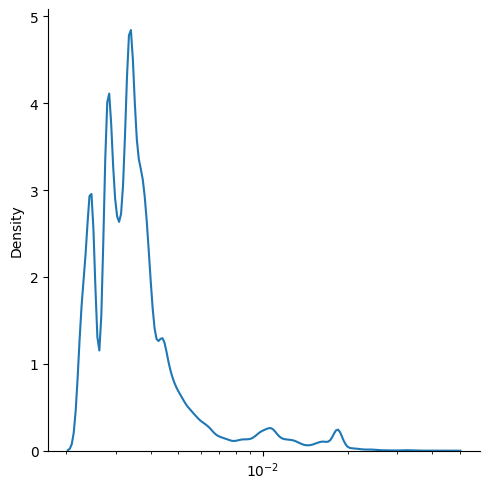

In [26]:
sns.displot(data=gower_distances_to_prototype_ctu, kind="kde", log_scale=True)

## Pairwise Gower Distances

In [27]:
pairwise_gower_distances_ctu = save_load_operation("pairwise_gower_distances_ctu", "npy", pairwise_gower_distances, dataset_ctu, SIZE_PAIR_SUBSAMPLES,cuda_device=cpu)

(1, 100000)

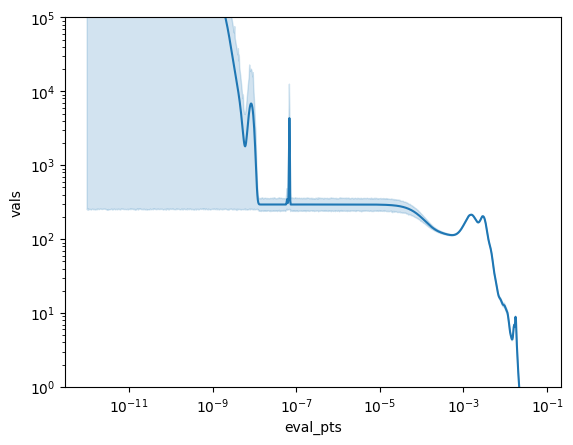

In [89]:
ctu_gower_kde_visframe = save_load_operation("ctu_gower_kde_visframe", "csv", distances_to_kde_dataframe, pairwise_gower_distances_ctu, log_scale=True)
plot = sns.lineplot(data=ctu_gower_kde_visframe, x="eval_pts", y="vals")
plot.set(xscale='log')
plot.set(yscale='log')
plot.set_ylim([1,10**5])

## Euklidean Distance to Prototype

In [29]:
euklid_distances_to_prototype_ctu = save_load_operation("euklid_distances_to_prototype_ctu", "npy", euklid_distance_to_prototype, dataset_ctu)

In [30]:
print(max(euklid_distances_to_prototype_ctu))
print(min(euklid_distances_to_prototype_ctu))

24960062242.264633
845619.670692522


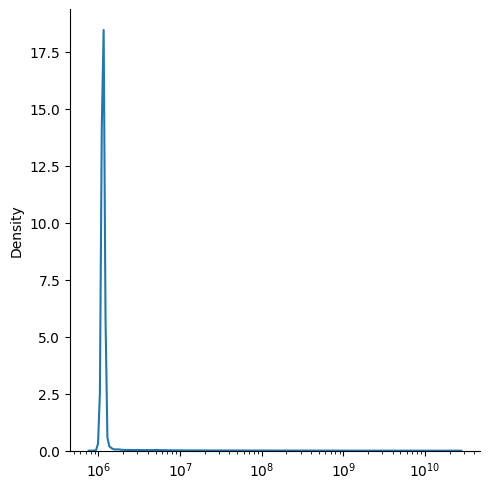

In [31]:
sns.displot(data=euklid_distances_to_prototype_ctu, kind="kde", log_scale=True)

## Pairwise Euklidian Distances

In [32]:
pairwise_euklidean_distances_ctu = save_load_operation("pairwise_euklidean_distances_ctu", "npy", pairwise_euclidean_distances, dataset_ctu, SIZE_PAIR_SUBSAMPLES)

(0.01, 100)

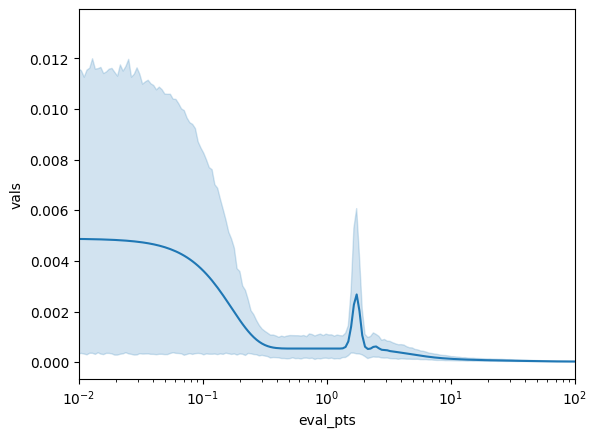

In [84]:
ctu_euklid_kde_visframe = save_load_operation("ctu_euklid_kde_visframe", "csv", distances_to_kde_dataframe, pairwise_euklidean_distances_ctu, log_scale=True)
plot = sns.lineplot(data=ctu_euklid_kde_visframe, x="eval_pts", y="vals")
plot.set(xscale='log')
plot.set_xlim([10**(-2),10**2])

## constraints

In [34]:
constraints_ctu = samples.ctu_13_neris.get_relation_constraints(dataset_ctu.metadata_source)
print(f"number of constraints: {len(constraints_ctu)}")
print(f"constraint types: {count_dict(parse_constraint_list(constraints_ctu))}")

number of constraints: 360
constraint types: {'EqualConstraint': 2, 'LessEqualConstraint': 358}


In [35]:
print_constraint_list(constraints_ctu)

Constraints:


,Constraint
0,((icmp_sum_s_1 + icmp_sum_s_3 + icmp_sum_s_8 + icmp_sum_s_10 + icmp_sum_s_21 + icmp_sum_s_22 + icmp_sum_s_25 + icmp_sum_s_53 + icmp_sum_s_80 + icmp_sum_s_110 + icmp_sum_s_123 + icmp_sum_s_135 + icmp_sum_s_138 + icmp_sum_s_161 + icmp_sum_s_443 + icmp_sum_s_445 + icmp_sum_s_993 + icmp_sum_s_OTHER + (udp_sum_s_1 + udp_sum_s_3 + udp_sum_s_8 + udp_sum_s_10 + udp_sum_s_21 + udp_sum_s_22 + udp_sum_s_25 + udp_sum_s_53 + udp_sum_s_80 + udp_sum_s_110 + udp_sum_s_123 + udp_sum_s_135 + udp_sum_s_138 + udp_sum_s_161 + udp_sum_s_443 + udp_sum_s_445 + udp_sum_s_993 + udp_sum_s_OTHER) + (tcp_sum_s_1 + tcp_sum_s_3 + tcp_sum_s_8 + tcp_sum_s_10 + tcp_sum_s_21 + tcp_sum_s_22 + tcp_sum_s_25 + tcp_sum_s_53 + tcp_sum_s_80 + tcp_sum_s_110 + tcp_sum_s_123 + tcp_sum_s_135 + tcp_sum_s_138 + tcp_sum_s_161 + tcp_sum_s_443 + tcp_sum_s_445 + tcp_sum_s_993 + tcp_sum_s_OTHER)) == (bytes_in_sum_s_1 + bytes_in_sum_s_3 + bytes_in_sum_s_8 + bytes_in_sum_s_10 + bytes_in_sum_s_21 + bytes_in_sum_s_22 + bytes_in_sum_s_25 + bytes_in_sum_s_53 + bytes_in_sum_s_80 + bytes_in_sum_s_110 + bytes_in_sum_s_123 + bytes_in_sum_s_135 + bytes_in_sum_s_138 + bytes_in_sum_s_161 + bytes_in_sum_s_443 + bytes_in_sum_s_445 + bytes_in_sum_s_993 + bytes_in_sum_s_OTHER + (bytes_out_sum_s_1 + bytes_out_sum_s_3 + bytes_out_sum_s_8 + bytes_out_sum_s_10 + bytes_out_sum_s_21 + bytes_out_sum_s_22 + bytes_out_sum_s_25 + bytes_out_sum_s_53 + bytes_out_sum_s_80 + bytes_out_sum_s_110 + bytes_out_sum_s_123 + bytes_out_sum_s_135 + bytes_out_sum_s_138 + bytes_out_sum_s_161 + bytes_out_sum_s_443 + bytes_out_sum_s_445 + bytes_out_sum_s_993 + bytes_out_sum_s_OTHER)))
1,((icmp_sum_d_1 + icmp_sum_d_3 + icmp_sum_d_8 + icmp_sum_d_10 + icmp_sum_d_21 + icmp_sum_d_22 + icmp_sum_d_25 + icmp_sum_d_53 + icmp_sum_d_80 + icmp_sum_d_110 + icmp_sum_d_123 + icmp_sum_d_135 + icmp_sum_d_138 + icmp_sum_d_161 + icmp_sum_d_443 + icmp_sum_d_445 + icmp_sum_d_993 + icmp_sum_d_OTHER + (udp_sum_d_1 + udp_sum_d_3 + udp_sum_d_8 + udp_sum_d_10 + udp_sum_d_21 + udp_sum_d_22 + udp_sum_d_25 + udp_sum_d_53 + udp_sum_d_80 + udp_sum_d_110 + udp_sum_d_123 + udp_sum_d_135 + udp_sum_d_138 + udp_sum_d_161 + udp_sum_d_443 + udp_sum_d_445 + udp_sum_d_993 + udp_sum_d_OTHER) + (tcp_sum_d_1 + tcp_sum_d_3 + tcp_sum_d_8 + tcp_sum_d_10 + tcp_sum_d_21 + tcp_sum_d_22 + tcp_sum_d_25 + tcp_sum_d_53 + tcp_sum_d_80 + tcp_sum_d_110 + tcp_sum_d_123 + tcp_sum_d_135 + tcp_sum_d_138 + tcp_sum_d_161 + tcp_sum_d_443 + tcp_sum_d_445 + tcp_sum_d_993 + tcp_sum_d_OTHER)) == (bytes_in_sum_d_1 + bytes_in_sum_d_3 + bytes_in_sum_d_8 + bytes_in_sum_d_10 + bytes_in_sum_d_21 + bytes_in_sum_d_22 + bytes_in_sum_d_25 + bytes_in_sum_d_53 + bytes_in_sum_d_80 + bytes_in_sum_d_110 + bytes_in_sum_d_123 + bytes_in_sum_d_135 + bytes_in_sum_d_138 + bytes_in_sum_d_161 + bytes_in_sum_d_443 + bytes_in_sum_d_445 + bytes_in_sum_d_993 + bytes_in_sum_d_OTHER + (bytes_out_sum_d_1 + bytes_out_sum_d_3 + bytes_out_sum_d_8 + bytes_out_sum_d_10 + bytes_out_sum_d_21 + bytes_out_sum_d_22 + bytes_out_sum_d_25 + bytes_out_sum_d_53 + bytes_out_sum_d_80 + bytes_out_sum_d_110 + bytes_out_sum_d_123 + bytes_out_sum_d_135 + bytes_out_sum_d_138 + bytes_out_sum_d_161 + bytes_out_sum_d_443 + bytes_out_sum_d_445 + bytes_out_sum_d_993 + bytes_out_sum_d_OTHER)))
2,((bytes_out_sum_s_1 / pkts_out_sum_s_1) <= 1500)
3,((bytes_out_sum_s_3 / pkts_out_sum_s_3) <= 1500)
4,((bytes_out_sum_s_8 / pkts_out_sum_s_8) <= 1500)
5,((bytes_out_sum_s_10 / pkts_out_sum_s_10) <= 1500)
6,((bytes_out_sum_s_21 / pkts_out_sum_s_21) <= 1500)
7,((bytes_out_sum_s_22 / pkts_out_sum_s_22) <= 1500)
8,((bytes_out_sum_s_25 / pkts_out_sum_s_25) <= 1500)
9,((bytes_out_sum_s_53 / pkts_out_sum_s_53) <= 1500)


# lcld_time

In [36]:
dataset_lcld = dataset_factory.get_dataset("lcld_time")  

## Basic Info 

In [37]:
basic_dataset_info(dataset_lcld)
basic_data_info(dataset_lcld)

### dataset info: lcld_time ###
['feature', 'min', 'max', 'mutable', 'type']
features per feature type: 
 {'real': 8, 'int': 4, 'cat': 2}
total number of features: 28
number of mutable features: 14
mutable feature types: 
 ['real', 'int', 'cat']
### data info: lcld_time ###
x shape: (1220092, 28)
x type: <class 'pandas.core.frame.DataFrame'>


## Gower Distances to prototype (mean feature values + majority class)

In [38]:
gower_distances_to_prototype_lcld = save_load_operation("gower_distances_to_prototype_lcld", "npy", gower_distance_to_prototype, dataset_lcld)

In [39]:
print(max(gower_distances_to_prototype_lcld))
print(min(gower_distances_to_prototype_lcld))

0.37723386988697055
0.04407135930689339


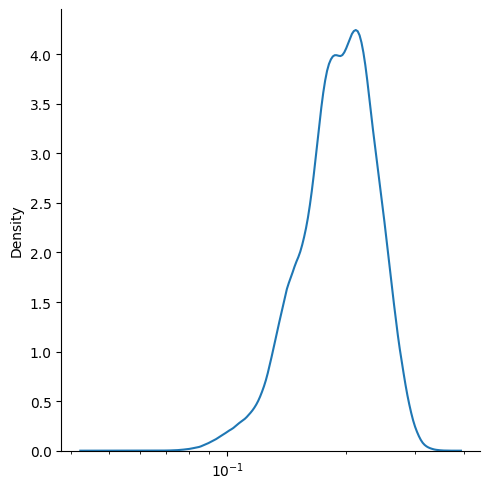

In [40]:
sns.displot(data=gower_distances_to_prototype_lcld, kind="kde", log_scale=True)

## Pairwise Gower Distances

In [41]:
pairwise_gower_distances_lcld = save_load_operation("pairwise_gower_distances_lcld", "npy", pairwise_gower_distances, dataset_lcld, SIZE_PAIR_SUBSAMPLES)

<Axes: xlabel='eval_pts', ylabel='vals'>

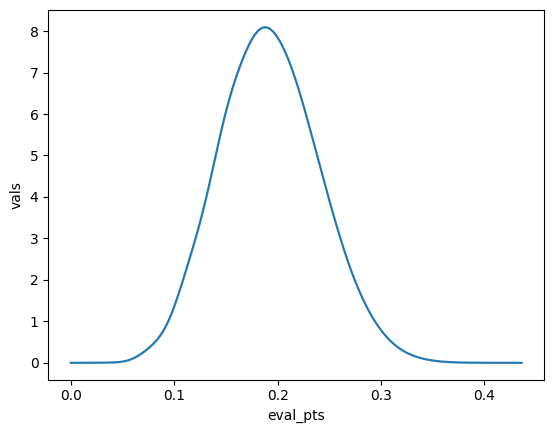

In [42]:
lcdl_gower_kde_visframe = save_load_operation("lcdl_gower_kde_visframe", "csv", distances_to_kde_dataframe, pairwise_gower_distances_lcld)
sns.lineplot(data=lcdl_gower_kde_visframe, x="eval_pts", y="vals")

## Euklid Distances to prototype

In [43]:
euklid_distances_to_prototype_lcld = save_load_operation("euklid_distances_to_prototype_lcld", "npy", euklid_distance_to_prototype, dataset_lcld)

In [44]:
print(max(euklid_distances_to_prototype_lcld))
print(min(euklid_distances_to_prototype_lcld))

10921019.563007124
332.48089889370266


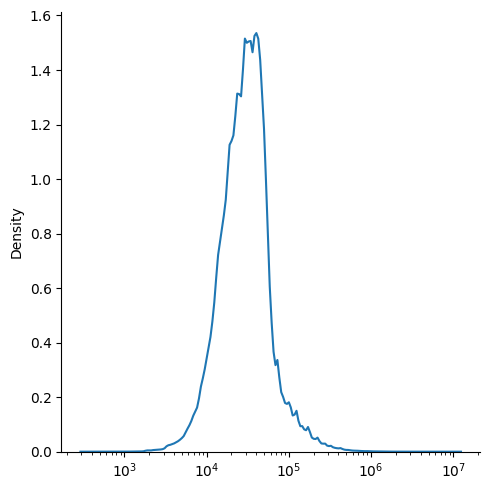

In [45]:
sns.displot(data=euklid_distances_to_prototype_lcld, kind="kde", log_scale=True)

## Pairwise Euklidean Distances

In [46]:
pairwise_euklidean_distances_lcdl = save_load_operation("pairwise_euklidean_distances_lcdl", "npy", pairwise_euclidean_distances, dataset_lcld, SIZE_PAIR_SUBSAMPLES)

[None]

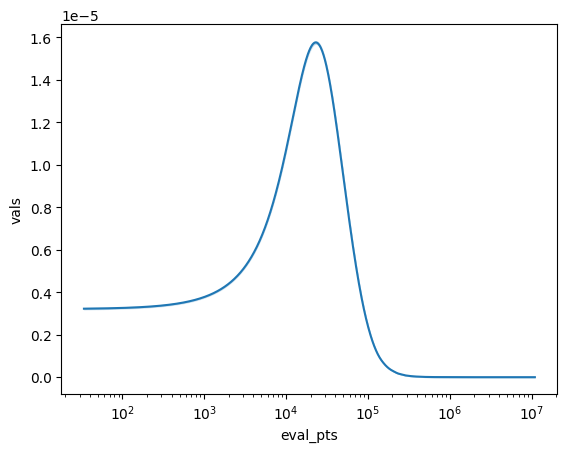

In [90]:
lcdl_euklid_kde_visframe = save_load_operation("lcdl_euklid_kde_visframe", "csv", distances_to_kde_dataframe, pairwise_euklidean_distances_lcdl, log_scale=True)
plot = sns.lineplot(data=lcdl_euklid_kde_visframe, x="eval_pts", y="vals")
plot.set(xscale='log')
#plot.set_xlim([10**(-3),10**2])

## constraints

In [48]:
constraints_lcld = samples.lcld.get_relation_constraints()
print(f"number of constraints: {len(constraints_lcld)}")
print(f"constraint types: {count_dict(parse_constraint_list(constraints_lcld))}")

number of constraints: 9
constraint types: {'EqualConstraint': 6, 'LessEqualConstraint': 2, 'OrConstraint': 1}


In [49]:
print_constraint_list(constraints_lcld)

Constraints:


,Constraint
0,(installment == (loan_amnt * (((int_rate / 1200) * ((1 + (int_rate / 1200)) ** term)) / (((1 + (int_rate / 1200)) ** term) - 1))))
1,(open_acc <= total_acc)
2,(pub_rec_bankruptcies <= pub_rec)
3,((term == 36) OR (term == 60))
4,(ratio_loan_amnt_annual_inc == (loan_amnt / annual_inc))
5,(ratio_open_acc_total_acc == (open_acc / total_acc))
6,(ratio_pub_rec_month_since_earliest_cr_line == (pub_rec / month_since_earliest_cr_line))
7,(ratio_pub_rec_bankruptcies_month_since_earliest_cr_line == (pub_rec_bankruptcies / month_since_earliest_cr_line))
8,(ratio_pub_rec_bankruptcies_pub_rec == (pub_rec_bankruptcies / pub_rec))


# url

In [50]:
dataset_url = dataset_factory.get_dataset("url")  

## Basic Info 

In [51]:
basic_dataset_info(dataset_url)
basic_data_info(dataset_url)

### dataset info: url ###
['feature', 'type', 'mutable', 'min', 'max']
features per feature type: 
 {'real': 5, 'int': 58}
total number of features: 63
number of mutable features: 63
mutable feature types: 
 ['real', 'int']
### data info: url ###
x shape: (11430, 63)
x type: <class 'pandas.core.frame.DataFrame'>


## Gower Distances to prototype (mean feature values + majority class)

In [52]:
distances_to_prototype_url = save_load_operation("distances_to_prototype_url", "npy", gower_distance_to_prototype, dataset_url)

In [53]:
print(max(distances_to_prototype_url))
print(min(distances_to_prototype_url))

0.3431603805108877
0.04645383095599675


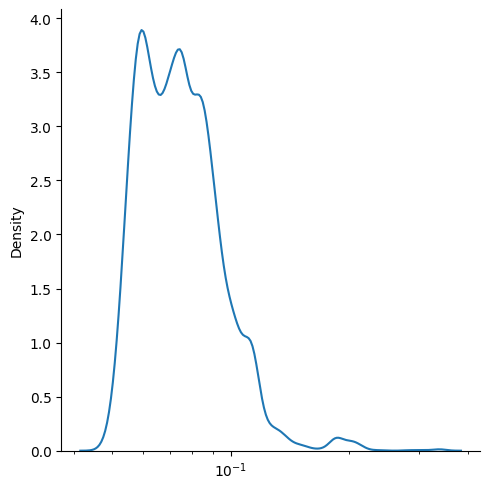

In [54]:
sns.displot(data=distances_to_prototype_url, kind="kde", log_scale=True)

## Pairwise Gower Distances

In [55]:
pairwise_gower_distances_url = save_load_operation("pairwise_gower_distances_url", "npy", pairwise_gower_distances, dataset_url, SIZE_PAIR_SUBSAMPLES)

[None]

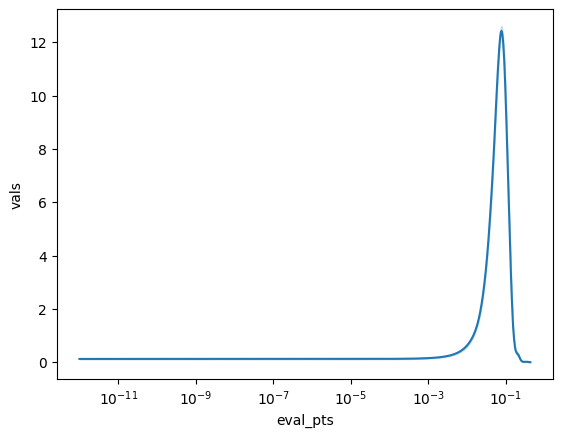

In [87]:
url_gower_kde_visframe = save_load_operation("url_gower_kde_visframe", "csv", distances_to_kde_dataframe, pairwise_gower_distances_url, log_scale=True)
plot = sns.lineplot(data=url_gower_kde_visframe, x="eval_pts", y="vals")
plot.set(xscale='log')

## Euklid Distances to Prototype

In [57]:
euklid_distances_to_prototype_url = save_load_operation("euklid_distances_to_prototype_url", "npy", euklid_distance_to_prototype, dataset_url)

In [58]:
print(max(euklid_distances_to_prototype_url))
print(min(euklid_distances_to_prototype_url))

9911229.47086109
2841.4311603293877


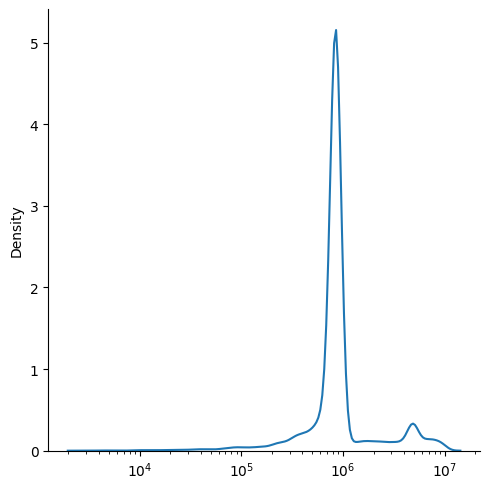

In [59]:
sns.displot(data=euklid_distances_to_prototype_url, kind="kde", log_scale=True)

## Pairwise Euklidean Distances

In [60]:
pairwise_euklidean_distances_url = save_load_operation("pairwise_euklidean_distances_url", "npy", pairwise_euclidean_distances, dataset_url, SIZE_PAIR_SUBSAMPLES)

<Axes: xlabel='eval_pts', ylabel='vals'>

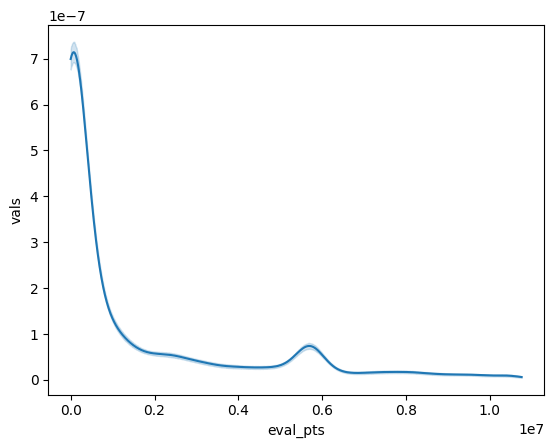

In [61]:
url_euklid_kde_visframe = save_load_operation("url_euklid_kde_visframe", "csv", distances_to_kde_dataframe, pairwise_euklidean_distances_url)
sns.lineplot(data=url_euklid_kde_visframe, x="eval_pts", y="vals")

## constraints

In [62]:
constraints_url = samples.url.get_relation_constraints()
print(f"number of constraints: {len(constraints_url)}")
print(f"constraint types: {count_dict(parse_constraint_list(constraints_url))}")

number of constraints: 14
constraint types: {'LessEqualConstraint': 8, 'OrConstraint': 6}


In [63]:
print_constraint_list(constraints_url)

Constraints:


,Constraint
0,(Feature_1 <= Feature_0)
1,((Feature_3 + Feature_4 + Feature_5 + Feature_6 + Feature_7 + Feature_8 + Feature_9 + Feature_10 + Feature_11 + Feature_12 + Feature_13 + Feature_14 + Feature_15 + Feature_16 + Feature_17 + (3 * Feature_19)) <= Feature_0)
2,((0 <= Feature_21) OR (0 < Feature_3))
3,((0 <= Feature_23) OR (0 < Feature_13))
4,(((3 * Feature_20) + (4 * Feature_21) + (2 * Feature_23)) <= Feature_0)
5,((0 <= Feature_19) OR (0 < Feature_25))
6,((0 <= Feature_2) OR (0 < Feature_25))
7,((0 <= Feature_28) OR (0 < Feature_25))
8,((0 <= Feature_31) OR (0 < Feature_26))
9,(Feature_38 <= Feature_37)


# wids

In [64]:
dataset_wids = dataset_factory.get_dataset("wids")

## Basic Info 

In [65]:
basic_dataset_info(dataset_wids)
basic_data_info(dataset_wids)

### dataset info: wids ###
['feature', 'min', 'max', 'mutable', 'type']
features per feature type: 
 {'real': 39, 'int': 60, 'cat': 9}
total number of features: 108
number of mutable features: 108
mutable feature types: 
 ['real', 'int', 'cat']
### data info: wids ###
x shape: (34776, 108)
x type: <class 'pandas.core.frame.DataFrame'>


## Gower Distances to prototype (mean feature values + majority class)

In [66]:
distances_to_prototype_wids = save_load_operation("distances_to_prototype_wids", "npy", gower_distance_to_prototype, dataset_wids)

In [67]:
print(max(distances_to_prototype_wids))
print(min(distances_to_prototype_wids))

0.3171111498371732
0.08660946028317147


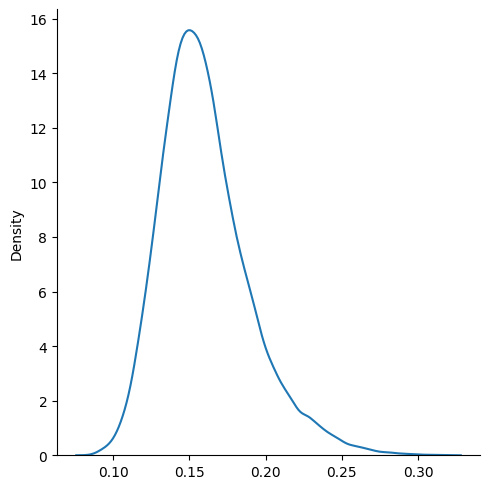

In [68]:
sns.displot(data=distances_to_prototype_wids, kind="kde")

## Pairwise Gower Distances

In [69]:
pairwise_gower_distances_wids = save_load_operation("pairwise_gower_distances_wids", "npy", pairwise_gower_distances, dataset_wids, SIZE_PAIR_SUBSAMPLES)

<Axes: xlabel='eval_pts', ylabel='vals'>

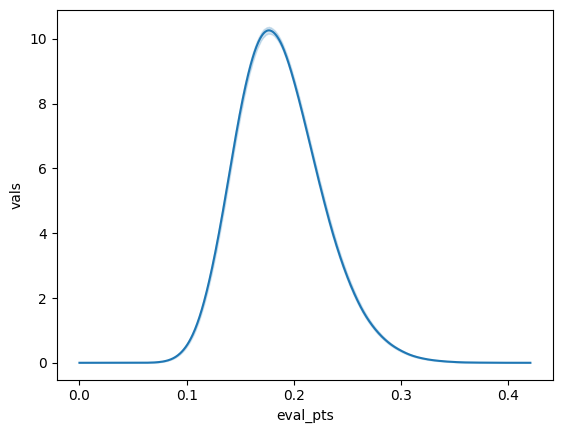

In [70]:
wids_gower_kde_visframe = save_load_operation("wids_gower_kde_visframe", "csv", distances_to_kde_dataframe, pairwise_gower_distances_wids)
sns.lineplot(data=wids_gower_kde_visframe, x="eval_pts", y="vals")

## Euklidean Distances to prototype

In [71]:
euklid_distances_to_prototype_wids = save_load_operation("euklid_distances_to_prototype_wids", "npy", euklid_distance_to_prototype, dataset_wids)

In [72]:
print(max(euklid_distances_to_prototype_wids))
print(min(euklid_distances_to_prototype_wids))

1669.2282818755064
102.73948953347747


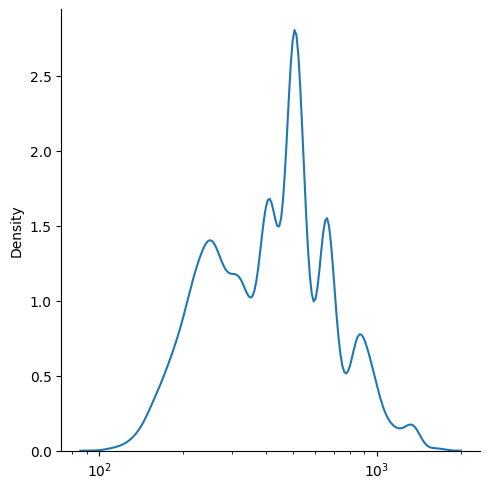

In [73]:
sns.displot(data=euklid_distances_to_prototype_wids, kind="kde", log_scale=True)

## Pairwise Euklidean Distances

In [74]:
pairwise_euklidean_distances_wids = save_load_operation("pairwise_euklidean_distances_wids", "npy", pairwise_euclidean_distances, dataset_wids, SIZE_PAIR_SUBSAMPLES)

<Axes: xlabel='eval_pts', ylabel='vals'>

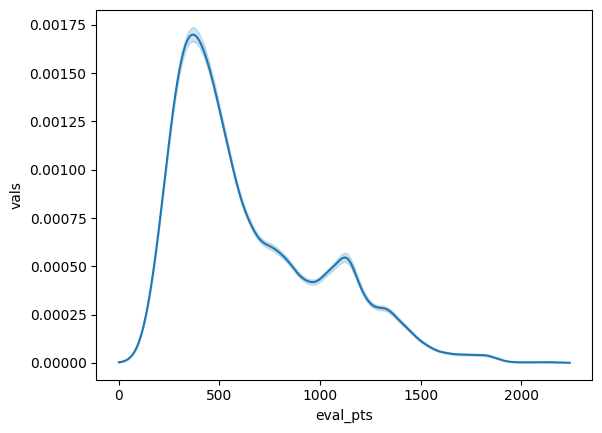

In [75]:
wids_euklid_kde_visframe = save_load_operation("wids_euklid_kde_visframe", "csv", distances_to_kde_dataframe, pairwise_euklidean_distances_wids)
sns.lineplot(data=wids_euklid_kde_visframe, x="eval_pts", y="vals")

## Constraints

In [76]:
constraints_wids = samples.wids.get_relation_constraints(dataset_wids.metadata_source)
print(f"number of constraints: {len(constraints_wids)}")
print(f"constraint types: {count_dict(parse_constraint_list(constraints_wids))}")

number of constraints: 31
constraint types: {'LessEqualConstraint': 31}


In [77]:
print_constraint_list(constraints_wids)

Constraints:


,Constraint
0,(Feature_34 <= Feature_33)
1,(Feature_36 <= Feature_35)
2,(Feature_38 <= Feature_37)
3,(Feature_40 <= Feature_39)
4,(Feature_42 <= Feature_41)
5,(Feature_44 <= Feature_43)
6,(Feature_46 <= Feature_45)
7,(Feature_48 <= Feature_47)
8,(Feature_50 <= Feature_49)
9,(Feature_52 <= Feature_51)
